In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
from astropy.io import fits
import astropy.units as u

import matplotlib
#matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
rootdir = Path("/Volumes/LaCie 8TB/wfsdat")
# use find to make this csv list
with open(rootdir / "reanalyze_csvs_2018_2019.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames, sort=True)

g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,35803,1,binospec,35803
f5,2672,1,f5,2672
mmirs,15979,1,mmirs,15979
newf9,1536,1,newf9,1536


In [4]:
data.tail()

,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,focus,...,seeing,tiltx,tilty,time,transx,transy,wavefront_rms,wfs,xcen,ycen
0,1.7348,74.800156,-9.754,2.888,15.027,35.200034,30.0,mmirs_wfs_0001.fits,-70.51,8896.91,...,0.883062,330.22,174.83,2019-09-16T06:43:16,-426.74,2865.36,1782.386525,mmirs,259.497837,231.499510
1,1.7233,74.919997,-2.587,0.694,15.018,35.469520,30.0,mmirs_wfs_0002.fits,-8.20,8830.91,...,0.736226,319.90,178.36,2019-09-16T06:44:44,-517.77,2618.77,431.981395,mmirs,257.498656,231.010760
2,1.7127,75.032349,1.545,-0.000,15.000,35.722517,30.0,mmirs_wfs_0003.fits,11.79,8854.99,...,1.034109,316.69,179.89,2019-09-16T06:45:57,-557.17,2546.53,416.357809,mmirs,255.523209,230.977242
3,1.3328,167.427721,1.661,0.000,13.703,48.616958,40.0,mmirs_wfs_0005.fits,-21.69,9138.13,...,0.451233,289.17,172.39,2019-09-16T10:07:58,-498.76,2332.68,602.221588,mmirs,249.501534,228.502617
4,1.3309,168.155876,-0.000,-0.000,13.666,48.708560,60.0,mmirs_wfs_0006.fits,-0.00,9131.23,...,0.483850,291.77,172.33,2019-09-16T10:09:56,-498.16,2399.48,196.544039,mmirs,248.495971,227.002486


In [5]:
data['comaerr'] = np.hypot(data['cc_x_err'], data['cc_y_err'])

In [17]:
fixed = data[(np.abs(data['focerr']) < 30.) & (data['comaerr'] < 5.) & (data['el'] != np.nan) & (data['focus'] != 0.0) & (data['el'] < 89.9) & (data['file'] != "f9wfs_20180830-151213.fits")]
fixed = fixed.dropna()

# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

In [18]:
f9 = fixed[(fixed['wfs'] == 'newf9') | (fixed['wfs'] == 'oldf9')][fixed['focus'] < 4500.]
f5 = fixed[fixed['wfs'] == 'f5']
mmirs = fixed[fixed['wfs'] == 'mmirs']
bino = fixed[fixed['wfs'] == 'binospec']

/Users/tim/conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [19]:
mmirs[mmirs['focus'] > 13000.]

,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,focus,...,tiltx,tilty,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr
ut,,,,,,,,,,,,,,,,,,,,,


In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mmirs['el'], mmirs['focus'], mmirs['osst'])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bino['el'], bino['focus'], bino['osst'])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(f5['el'], f5['focus'], f5['osst'])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(f9['el'], f9['focus'], f9['osst'])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
fixed.to_csv("../raw_data/2018_2019_wfs_loose.csv")

In [8]:
mmirs['xcen'].mean(), mmirs['ycen'].mean()

(245.65565737929185, 252.87883871761397)

In [9]:
bino['xcen'].mean(), bino['ycen'].mean()

(269.1207510089737, 252.03852415953796)

In [10]:
f5['xcen'].mean(), f5['ycen'].mean()

(241.1208010799222, 250.46755956847164)

In [11]:
f9['xcen'].mean(), f9['ycen'].mean()

(463.1591747433346, 461.76854167900495)

In [12]:
mmirs['xcen'].std(), mmirs['ycen'].std()

(14.477595301716818, 8.713435536429525)

In [13]:
bino['xcen'].std(), bino['ycen'].std()

(15.625843068598646, 8.117188077057339)

In [14]:
f5['xcen'].std(), f5['ycen'].std()

(19.565245351211637, 24.415530784933537)

In [15]:
f9['xcen'].std(), f9['ycen'].std()

(205.29095798048976, 132.78210456439623)

<IPython.core.display.Javascript object>


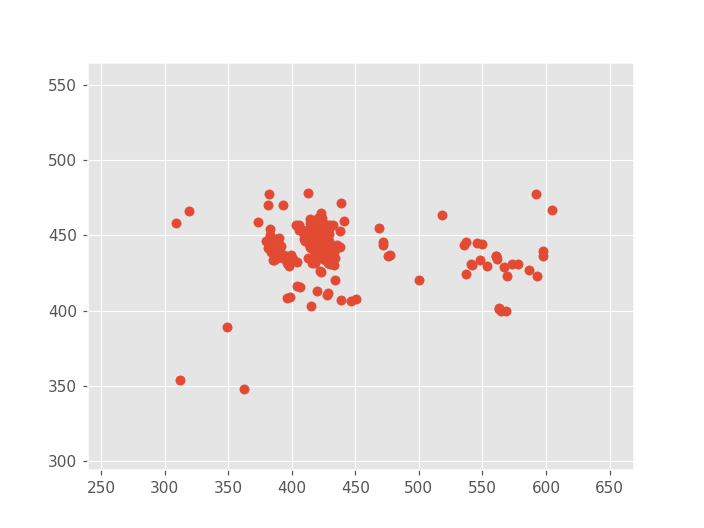

In [16]:
plt.scatter(f9['xcen'], f9['ycen'])
plt.show()